In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

### Priprava podatkov

In [3]:
lj_dez = pd.read_csv("../ljubljana_dez_2010_2023.csv")

# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, pri katerih je količina padlega dežja vsaj 1.0 mm/h.

In [4]:
# Maska za dež
rain_mask = (lj_dez['SkupenDez'] < 1.0)

lj_dez = lj_dez[rain_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

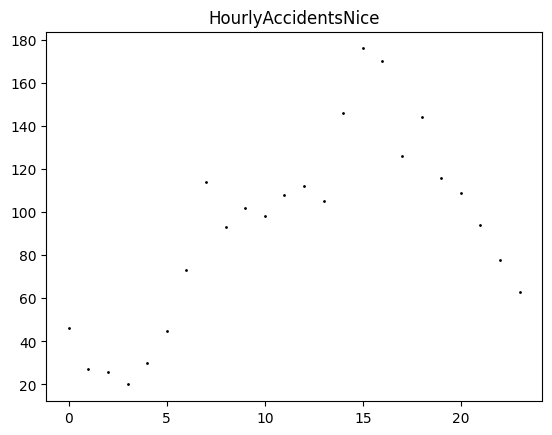

In [5]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNice"])

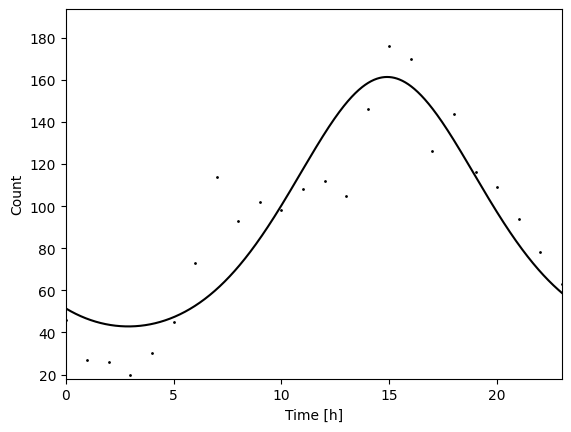

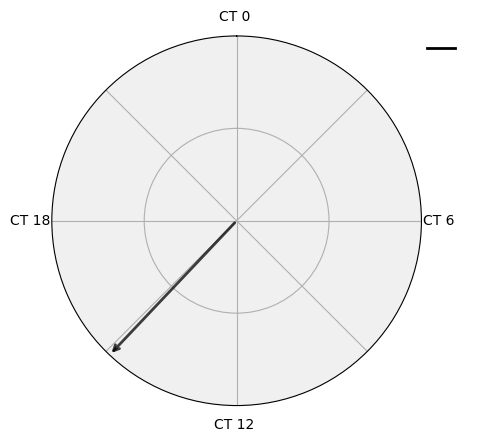

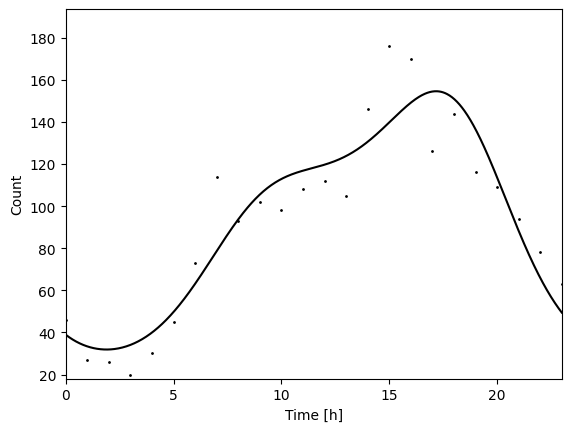

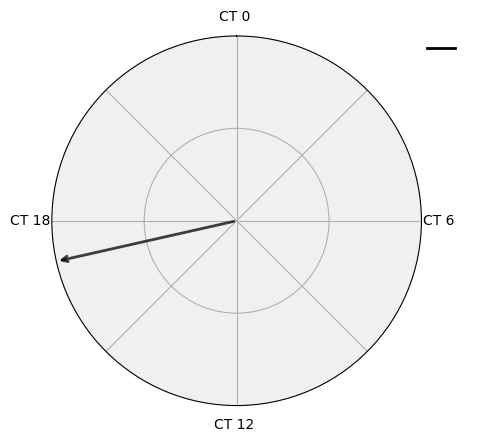

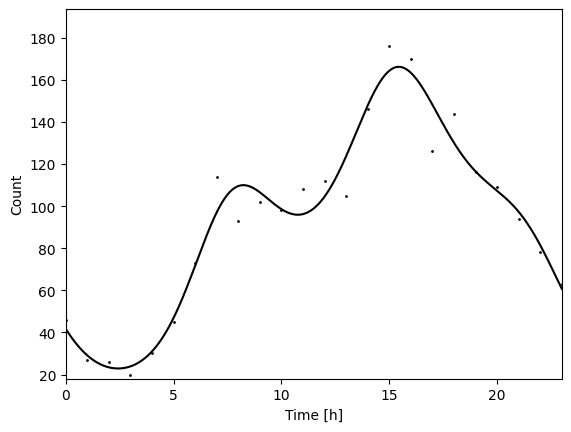

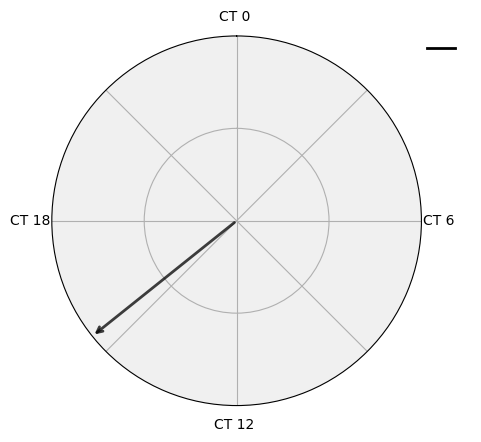

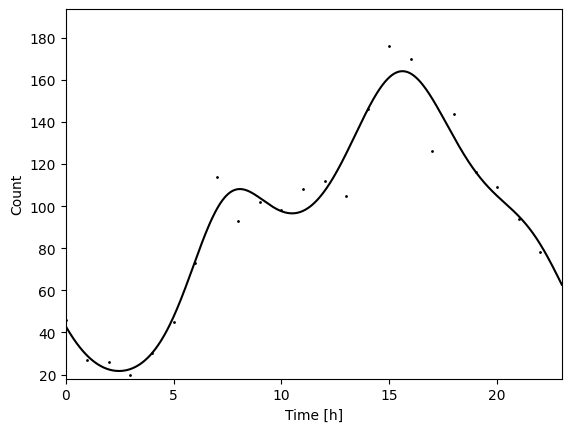

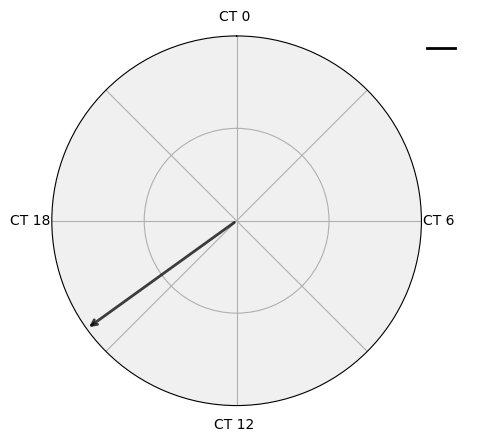

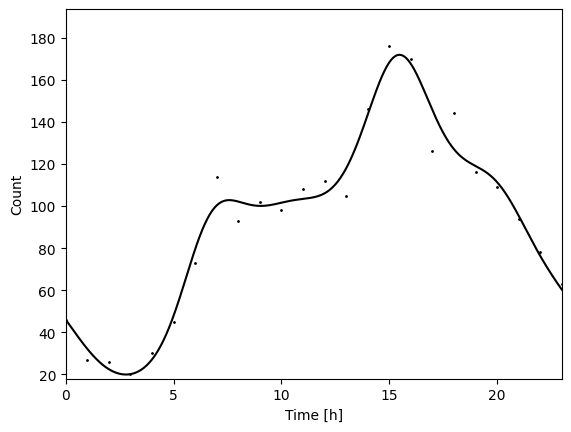

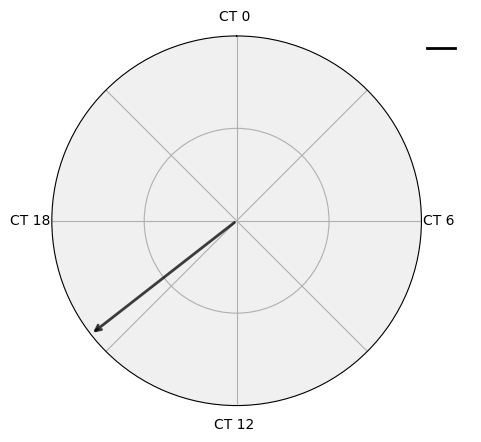

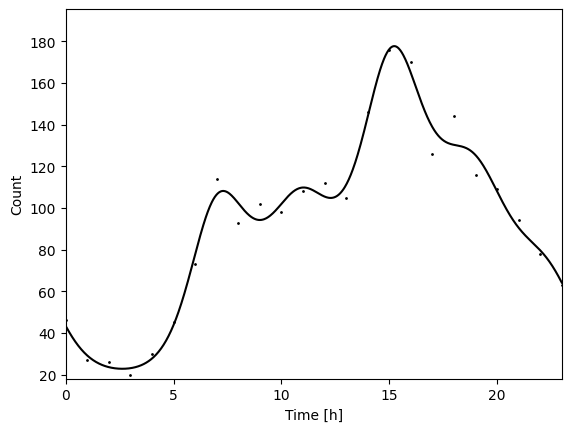

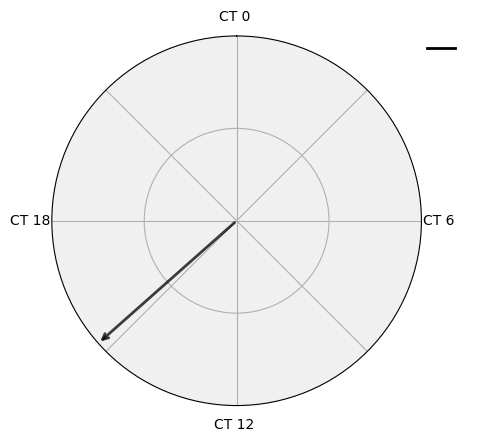

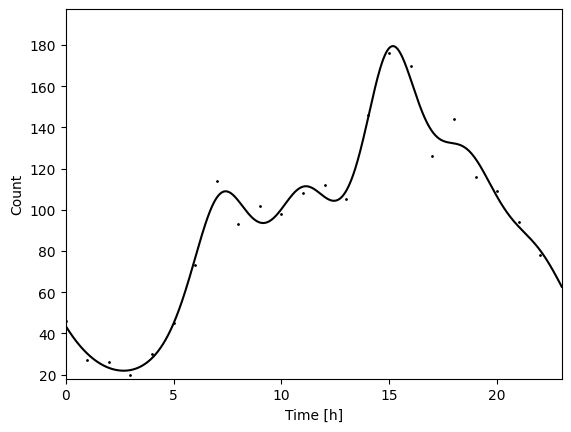

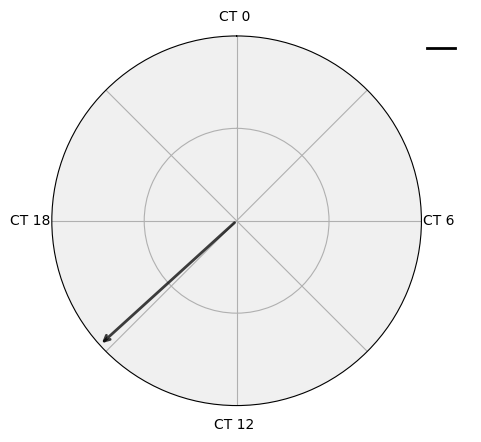

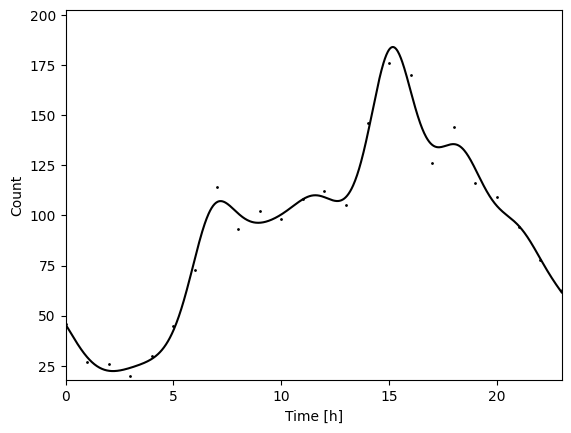

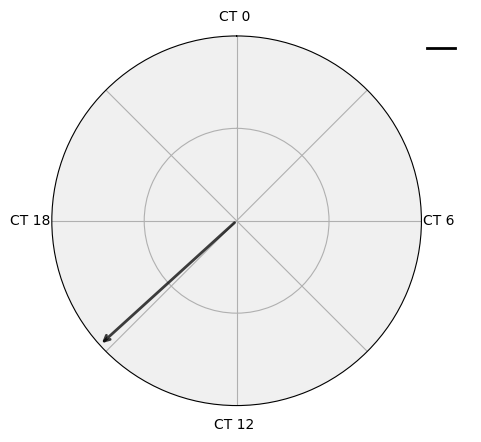

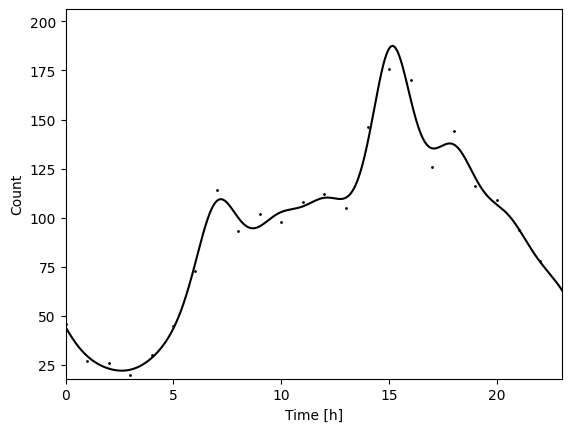

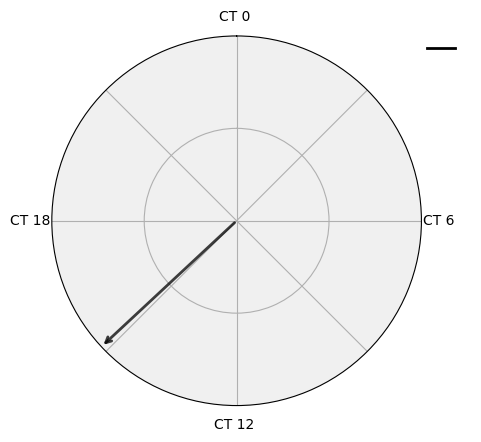

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


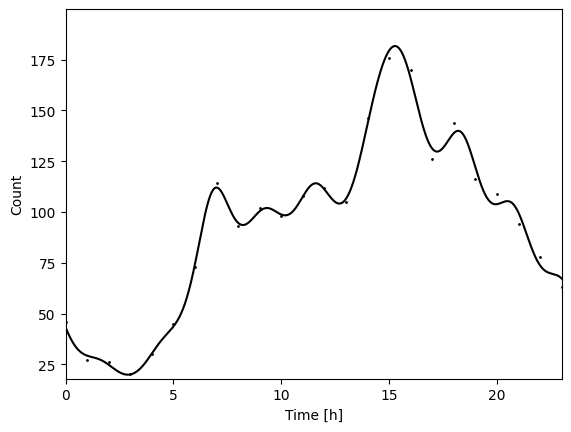

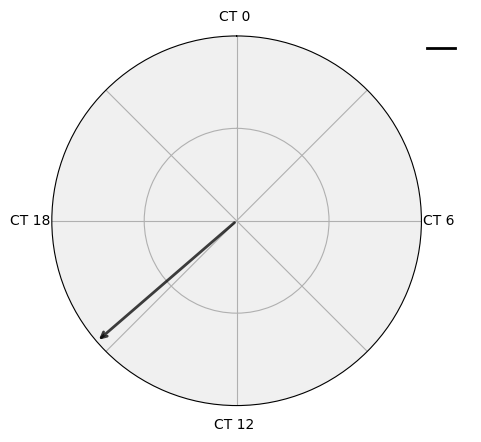

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNice', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24.0,1.0,1.282723e-09,1.282723e-09,9525.948411,-106.062954,0.161804,59.257252,2.383711,102.104461,[14.894894894894895],[161.36171299987797],[2.8828828828828827],[42.84751135004846]
1,HourlyAccidentsNice,24.0,2.0,1.311978e-11,1.457753e-11,6164.742343,-98.098006,0.224750,61.357741,1.792500,93.229337,[17.153153153153152],[154.5858592884928],[1.8738738738738738],[31.872176822935142]
2,HourlyAccidentsNice,24.0,3.0,1.960274e-16,4.512975e-16,2078.210351,-83.491115,0.340185,71.662084,2.245342,94.525331,"[8.216216216216216, 15.423423423423424]","[109.96670743290669, 166.1847717236775]",[2.4024024024024024],[22.864898616489704]
3,HourlyAccidentsNice,24.0,4.0,1.733824e-15,2.167279e-15,2088.995849,-82.946434,0.344490,71.218557,2.195027,92.893333,"[8.072072072072071, 15.615615615615615]","[108.1153956812948, 164.11188976071188]",[2.4504504504504503],[21.67597860336196]
4,HourlyAccidentsNice,24.0,5.0,5.603156e-16,8.004509e-16,1380.936537,-79.071180,0.375115,75.978923,2.232764,95.904388,"[7.591591591591592, 15.471471471471471]","[102.81897980355741, 171.88331069244074]",[2.7867867867867866],[19.925464769987673]
5,HourlyAccidentsNice,24.0,6.0,3.996806e-17,1.998403e-16,848.824834,-73.626015,0.418147,77.453384,2.295658,100.230184,"[7.303303303303303, 11.05105105105105, 15.2312...","[108.15322280361553, 109.80581237372613, 177.6...","[2.6426426426426426, 8.984984984984985]","[22.777527372310246, 94.20796521593458]"
6,HourlyAccidentsNice,24.0,7.0,2.064460e-16,4.512975e-16,808.226875,-73.001572,0.423082,78.775820,2.308237,100.666700,"[7.3993993993994, 11.147147147147146, 15.18318...","[108.96690414252193, 111.42823302001182, 179.4...","[2.6906906906906904, 9.12912912912913]","[21.890879677472594, 93.57560708700716]"
7,HourlyAccidentsNice,24.0,8.0,2.256487e-16,4.512975e-16,626.249455,-70.753148,0.440851,80.884917,2.308237,103.201417,"[7.207207207207207, 11.57957957957958, 15.1831...","[107.16245586398944, 110.08204629104779, 184.0...","[2.21021021021021, 8.936936936936936]","[22.316798949371364, 96.33553393578677]"
8,HourlyAccidentsNice,24.0,9.0,4.781009e-16,7.968349e-16,636.874270,-69.346456,0.451968,82.697550,2.320816,104.798617,"[7.207207207207207, 12.156156156156156, 15.135...","[109.43731812141615, 110.26512462753408, 187.4...","[2.5945945945945947, 8.696696696696696]","[22.10106761537174, 94.61964320652645]"
9,HourlyAccidentsNice,24.0,10.0,9.970461e-19,9.970461e-18,253.299994,-59.961939,0.526132,80.886994,2.283079,100.771009,"[7.015015015015015, 9.32132132132132, 11.57957...","[111.98973362597545, 101.9261848019516, 114.08...","[2.8828828828828827, 8.216216216216216, 10.186...","[19.884015249397454, 93.55200840108633, 98.315..."


### Katero je najboljše število komponent

In [8]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24.0,3.0,1.960274e-16,4.512975e-16,2078.210351,-83.491115,0.340185,71.662084,2.245342,94.525331,"[8.216216216216216, 15.423423423423424]","[109.96670743290669, 166.1847717236775]",[2.4024024024024024],[22.864898616489704]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


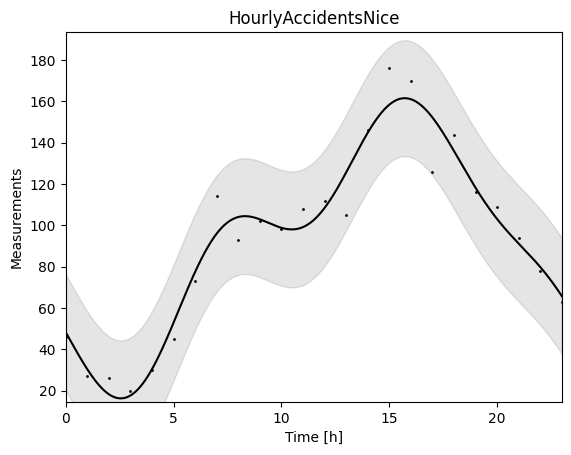

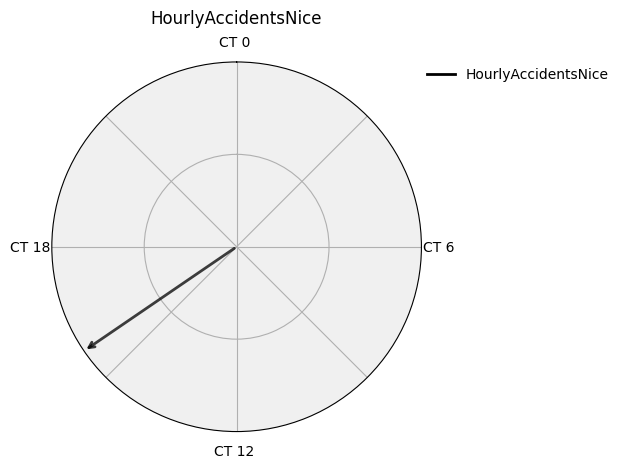

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

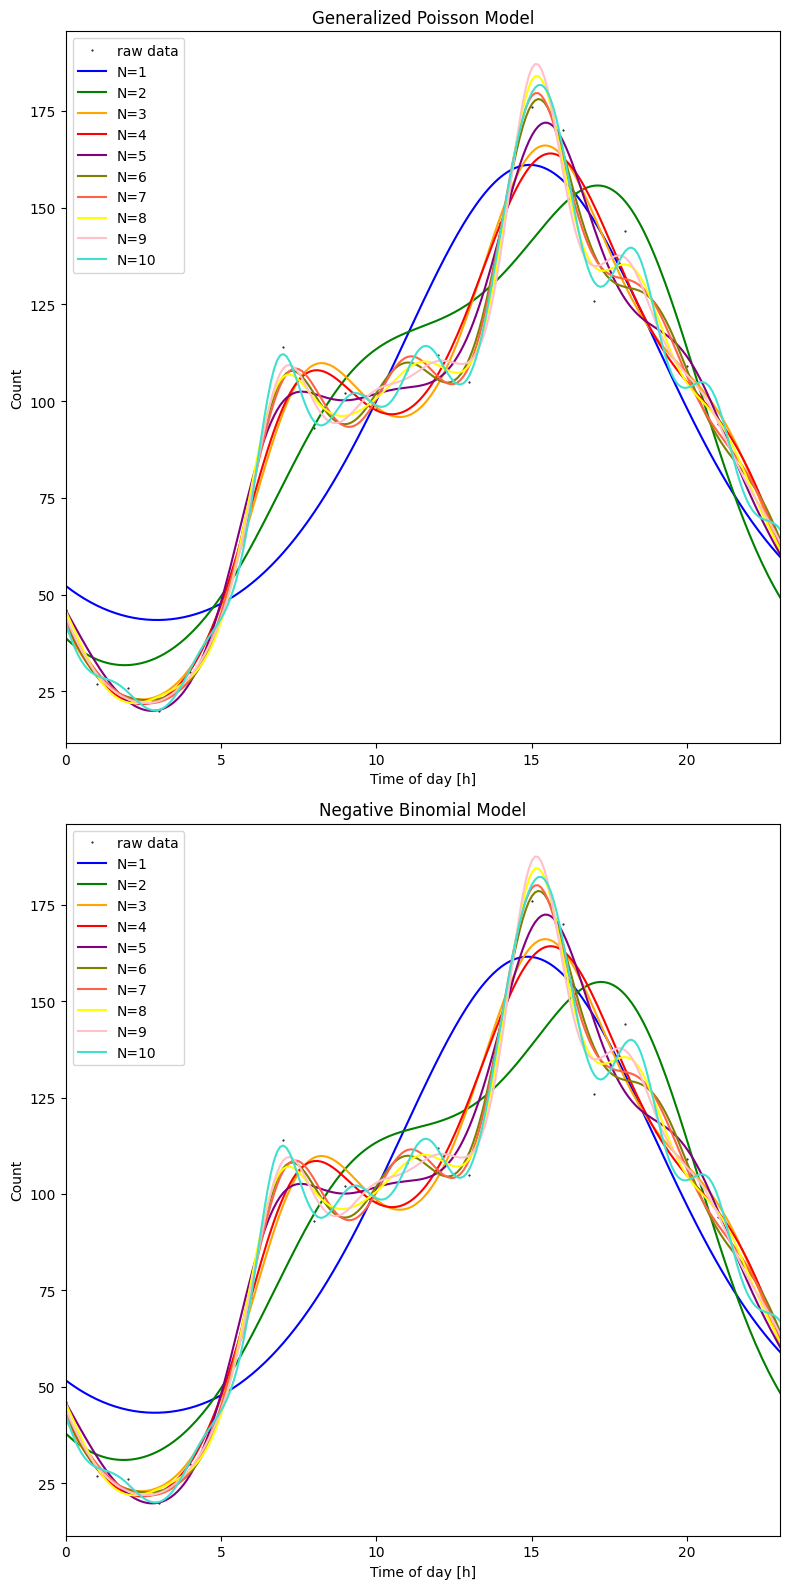

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,58.79,102.26,[14.91],[161.04],1.303852e-09,9416.517478,220.158584,224.870799,-106.079292,"[-3.671551856780077, -4.315565640162198, -4.14...",92.880069,"[52.30564459494537, 47.22983365062742, 44.3412...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[52.30564459494537, 51.69238889419226, 51.1032..."
1,gen_poisson,2,61.96,93.76,[17.12],[155.72],1.367827e-11,6168.214769,208.282322,215.350645,-98.141161,"[-3.6026463107356577, -3.226074524915237, -3.1...",92.976457,"[38.83035801778164, 33.29323260562499, 31.8179...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[38.83035801778164, 38.069287366620486, 37.357..."
2,gen_poisson,3,71.57,94.49,[15.42],[166.06],1.985435e-16,2077.451924,183.008951,192.433381,-83.504475,"[-2.974800535763137, -2.566628458896197, -2.59...",92.541667,"[41.75571396923101, 29.129694879423432, 23.465...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[41.75571396923101, 40.163687524291326, 38.642..."
3,gen_poisson,4,71.11,92.89,[15.62],[164.01],1.831031e-15,2086.108363,186.009834,197.790373,-83.004917,"[-2.8498861325295977, -2.5511516442794147, -2....",92.541667,"[42.935240927865195, 28.95939536019577, 22.478...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[42.935240927865195, 41.20468019788499, 39.542..."
4,gen_poisson,5,75.97,95.97,[15.42],[171.94],1.254799e-15,1376.738732,183.901108,198.037754,-79.950554,"[-2.7243335517994893, -3.0107617072541686, -2....",92.541667,"[46.0582389417652, 32.12577047993172, 22.48327...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[46.0582389417652, 44.60899929601082, 43.16052..."
5,gen_poisson,6,77.63,100.42,[15.22],[178.06],8.600483e-16,847.873751,182.038975,198.531729,-77.019488,"[-2.807946984738493, -2.5743178683185413, -2.5...",92.541667,"[43.46899214843375, 29.21000144389907, 23.5730...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[43.46899214843375, 41.60639243444807, 39.8324..."
6,gen_poisson,7,78.82,100.77,[15.22],[179.58],5.828820e-15,807.312291,185.542016,204.390878,-76.771008,"[-2.794053261522592, -2.6824303116317694, -2.6...",92.541667,"[43.675893300181194, 30.15008860763107, 23.256...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[43.675893300181194, 42.0093989719912, 40.4099..."
7,gen_poisson,8,81.01,103.00,[15.22],[184.01],2.083079e-14,625.875824,187.897038,209.102007,-75.948519,"[-2.7240321166293526, -2.5806228068878276, -2....",92.541667,"[45.87482688934219, 29.273989560818787, 22.161...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[45.87482688934219, 44.084265125339776, 42.278..."
8,gen_poisson,9,82.56,104.55,[15.12],[187.11],9.195894e-14,636.244275,190.994242,214.555318,-75.497121,"[-2.7546673498006697, -2.6079479114995863, -2....",92.541667,"[44.42137948000163, 29.534889585808287, 23.020...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[44.42137948000163, 42.5250433093919, 40.70210..."
9,gen_poisson,10,80.79,100.90,"[15.32, 18.22]","[181.69, 139.68]",1.066761e-13,251.807867,191.118900,217.036085,-73.559450,"[-2.8503738847859452, -2.5652546712215347, -2....",92.541667,"[42.92963462993445, 29.11506655092491, 24.8561...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[42.92963462993445, 40.41621225870742, 38.1482..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

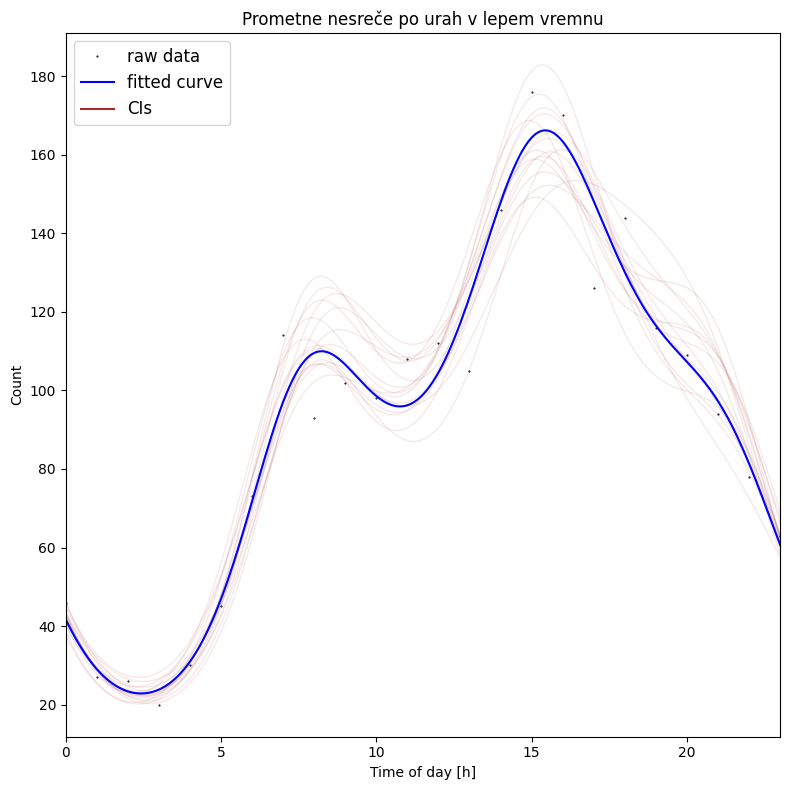

Intervali zaupanja:


,0,1
0,4.350506,4.424778
1,-0.525175,-0.414595
2,-0.665880,-0.529008
3,-0.320107,-0.172500
4,-0.232556,-0.141071
5,-0.234432,-0.114992
6,0.076990,0.171433
7,-0.552545,0.059828


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah v lepem vremnu', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,71.57
mesor,94.49
peaks,[15.42]
heights,[166.06]
amplitude_CIs,"[66.31, 79.28]"
mesor_CIs,"[88.55, 102.98]"
peaks_CIs,"[14.81, 16.07]"
heights_CIs,"[155.08, 182.04]"
